掛接雲端硬碟

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

# Part 1: Network Training
This tutorial demonstrates how to train the FNN-based model for the core loss prediction. The network model will be trained based on Dataset_tri.json and saved as a state dictionary (.sd) file.


# Step 0: Import Packages
In this demo, the neural network is synthesized using the PyTorch framework. Please install PyTorch according to the [official guidance](https://pytorch.org/get-started/locally/) , then import PyTorch and other dependent modules.

In [2]:
# Import necessary packages


import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import math
import csv
from pathlib import Path

# Step 1: Define Network Structure
In this part, we define the structure of the feedforward neural network. Refer to the [PyTorch document](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) for more details.
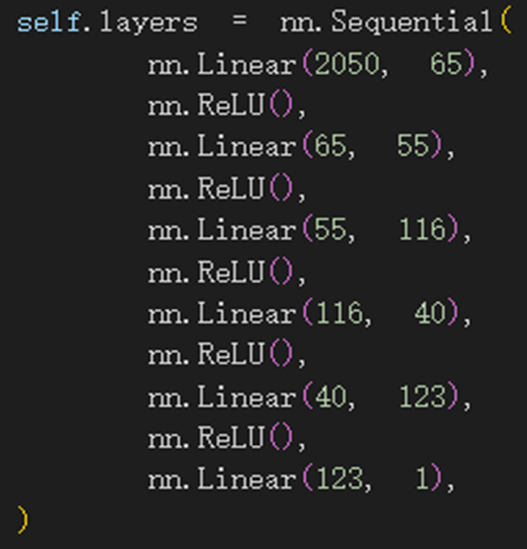

In [3]:
# Define model structures and functions

class Net(nn.Module):
    def __init__(self, load_pretrained: bool = False, pretrained_model_path :str  = "None"):
        super(Net, self).__init__()
        # Define a fully connected layers model with three inputs (frequency, flux density, duty ratio) and one output (power loss).
        self.layers = nn.Sequential(
            nn.Linear(1026, 65),
            nn.ReLU(),
            nn.Linear(65, 55),
            nn.ReLU(),
            nn.Linear(55, 116),
            nn.ReLU(),
            nn.Linear(116, 40),
            nn.ReLU(),
            nn.Linear(40, 123),
            nn.ReLU(),
            nn.Linear(123, 1),
        )
        if load_pretrained and pretrained_model_path is not None:
          self.load_pretrained_model(pretrained_model_path)

    def forward(self, x):
        return self.layers(x)

    def load_pretrained_model(self, path):
      # 讀取並設置預訓練模型的權重
      pretrained_dict = torch.load(path)
      # 獲取當前模型的狀態字典
      model_dict = self.state_dict()
      # 更新當前模型的狀態字典中的權重
      model_dict.update(pretrained_dict)
      # 更新模型字典以匹配預訓練模型的字典
      self.load_state_dict(model_dict)
      print('Model is load')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Step 2: Load the Dataset
In this part, we load and pre-process the dataset for the network training and testing. In this demo, a small dataset containing triangular waveforms measured with Material Brrite material under different frequency, flux density, and duty ratio is used, which can be downloaded from the [MagNet GitHub](https://github.com/PrincetonUniversity/Magnet) repository under "tutorial".

In [4]:
# Load the dataset

material_name = 'N49'
# material_b_mix

# B_file_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Database/{material_name}/B_Field.csv'
B_file_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Database/{material_name}/B_waveform.csv'
Freq_file_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Database/{material_name}/Frequency.csv'
Temp_file_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Database/{material_name}/Temperature.csv'
Power_file_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Database/{material_name}/Volumetric_Loss.csv'

# Pre-Train
pretrain_model_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Final_test/FNN/Model/Test_Split/spilt622/Model_3E6_77_78_N30_optuna2_NoPretrain.sd'
Transfer_use = False
Pretrain = 'NoPretrain' #Pretrain/NoPretrain
spilt_way = 'spilt622' #spilt622/spilt2/midterm_material

# Output
output_sd_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Final_test/FNN/Model/Test_Split/{spilt_way}/Model_{material_name}_optuna2_{Pretrain}.sd'
output_pred_path = f'/content/drive/MyDrive/Colab_Notebooks/MagNet/Final_test/FNN/Loss/withoutH_Transfer/{spilt_way}/pred_loss_{material_name}_optuna2_{Pretrain}.csv'

def get_dataset():

    B = read_csv(B_file_path)
    Freq = read_csv(Freq_file_path)
    Temp = read_csv(Temp_file_path)
    #H = read_csv(H_file_path)
    Power = read_csv(Power_file_path)

    # Compute labels
    # There's approximalely an exponential relationship between Loss-Freq and Loss-Flux.
    # Using logarithm may help to improve the training.
    Freq = np.log10(Freq)
    Temp = np.array(Temp)
    Power = np.log10(Power)

    # Reshape data
    Freq = torch.from_numpy(Freq).float().view(-1, 1)
    B = torch.from_numpy(B).float().view((-1,1024,1))
    #H = torch.from_numpy(H).float().view((-1,1024,1))
    Temp = torch.from_numpy(Temp).view(-1, 1)
    Power = Power.reshape((-1,1))

    # Normalize
    B = (B-torch.mean(B))/torch.std(B).numpy()
    #H = (H-torch.mean(H))/torch.std(H).numpy()
    Freq = (Freq-torch.mean(Freq))/torch.std(Freq).numpy()
    Temp = (Temp-torch.mean(Temp))/torch.std(Temp).numpy()

    B = np.squeeze(B, axis=2)
    #H = np.squeeze(H, axis=2)

    print(np.shape(Freq))
    print(np.shape(B))
    #print(np.shape(H))
    print(np.shape(Temp))
    print(np.shape(Power))

    temp = np.concatenate((Freq,B,Temp),axis=1)

    in_tensors = torch.from_numpy(temp).view(-1, 1026)
    out_tensors = torch.from_numpy(Power).view(-1, 1)

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)

def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            values = [float(value) for value in row]
            data.append(values)
    return np.array(data)

# Step 3: Training and Testing the Model
In this part, we program the training and testing procedure of the network model. The loaded dataset is randomly split into training set, validation set, and test set. The output of the training is the state dictionary file (.sd) containing all the trained parameter values.

In [ ]:
# Config the model training

def main():
    # Reproducibility
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hyperparameters
    NUM_EPOCH = 2000
    BATCH_SIZE = 128
    DECAY_EPOCH = 423
    DECAY_RATIO = 0.458
    LR_INI = 0.005
    best_loss = math.inf
    early_stop_count = 0
    early_stop = 500
    # Select GPU as default device
    device = torch.device("cuda")

    # Load dataset
    dataset = get_dataset()

    train_size = int(0.8 * len(dataset))
    train_size = int(0.6 * len(dataset))
    valid_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - valid_size
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
    kwargs = {'num_workers': 0, 'pin_memory': True, 'pin_memory_device': "cuda"}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

    # Setup network
    # net = Net().double().to(device)
    net = Net(Transfer_use ,pretrain_model_path).double().to(device)

    # Log the number of parameters
    print("Number of parameters: ", count_parameters(net))

    # Setup optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=LR_INI)

    # Train the network
    for epoch_i in range(NUM_EPOCH):

        # Train for one epoch
        epoch_train_loss = 0
        net.train()
        optimizer.param_groups[0]['lr'] = LR_INI* (DECAY_RATIO ** (0+ epoch_i // DECAY_EPOCH))

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Compute Validation Loss
        with torch.no_grad():
            epoch_valid_loss = 0
            for inputs, labels in valid_loader:
                outputs = net(inputs.to(device))
                loss = criterion(outputs, labels.to(device))

                epoch_valid_loss += loss.item()

        if (epoch_i+1)%5 == 0:
          print(f"Epoch {epoch_i+1:2d} "
              f"Train {epoch_train_loss / len(train_dataset) * 1e5:.5f} "
              f"Valid {epoch_valid_loss / len(valid_dataset) * 1e5:.5f}")

        # Early stop
        epoch_valid_loss = epoch_valid_loss / len(valid_dataset) * 1e5
        if epoch_valid_loss < best_loss:
          best_loss = epoch_valid_loss
          torch.save(net.state_dict(), output_sd_path)
          print('Saving model with loss {:.3f}...'.format(best_loss))
          early_stop_count = 0
        else:
          early_stop_count += 1

        if early_stop_count >= early_stop:
          print('Model is not improving, so we halt the training session.')
          break
    print("Training finished! Model is saved!")


    # Load the best model  ====================================================
    net.load_state_dict(torch.load(output_sd_path))
    print("Best model is load to test")
    # =====================================================================

    # Evaluation
    net.eval()
    y_meas = []
    y_pred = []
    with torch.no_grad():
            y_pred.append(net(inputs.to(device)))
            y_meas.append(labels.to(device))

    y_meas = torch.cat(y_meas, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print(f"Test Loss: {F.mse_loss(y_meas, y_pred).item() / len(test_dataset) * 1e5:.5f}")

    yy_pred = 10**(y_pred.cpu().numpy())
    yy_meas = 10**(y_meas.cpu().numpy())
    print("yy_pred :", yy_pred.shape)
    print("yy_meas :", yy_meas.shape)

    with open(output_pred_path, "w") as f:
        np.savetxt(f, (yy_pred))
        f.close()
    #with open("/content/drive/MyDrive/材料/Material B/Pred_loss/meas_loss_Material B_optuna3.csv", "w") as f:
        #np.savetxt(f, (yy_meas))
        #f.close()

    # Relative Error
    Error_re = abs(yy_pred-yy_meas)/abs(yy_meas)*100
    Error_re_avg = np.mean(Error_re)
    Error_re_rms = np.sqrt(np.mean(Error_re ** 2))
    Error_re_95prct = np.percentile(Error_re, 95)
    Error_re_99prct = np.percentile(Error_re, 99)
    Error_re_max = np.max(Error_re)

    print(f"Relative Error: {Error_re_avg:.8f}")
    print(f"AVG Error: {Error_re_avg:.8f}")
    # print(f"RMS Error: {Error_re_rms:.8f}")
    print(f"95-PRCT Error: {Error_re_95prct:.8f}")
    print(f"99th Percentile Error: {Error_re_99prct:.8f}")
    print(f"MAX Error: {Error_re_max:.8f}")


if __name__ == "__main__":
    main()

torch.Size([5000, 1])
torch.Size([5000, 1024])
torch.Size([5000, 1])
(5000, 1)
Number of parameters:  86728
Saving model with loss 3481.507...
Saving model with loss 1450.607...
Saving model with loss 178.980...
Saving model with loss 115.255...
Epoch  5 Train 106.73667 Valid 98.20437
Saving model with loss 98.204...
Saving model with loss 89.694...
Saving model with loss 86.885...
Saving model with loss 84.798...
Saving model with loss 60.291...
Epoch 10 Train 56.02172 Valid 49.97248
Saving model with loss 49.972...
Saving model with loss 39.286...
Saving model with loss 24.745...
Saving model with loss 16.098...
Epoch 15 Train 22.60598 Valid 9.68722
Saving model with loss 9.687...
Epoch 20 Train 8.51619 Valid 8.36950
Saving model with loss 8.370...
Saving model with loss 5.923...
Saving model with loss 5.592...
Epoch 25 Train 8.82550 Valid 5.12979
Saving model with loss 5.130...
Epoch 30 Train 9.24650 Valid 7.12181
Epoch 35 Train 11.69200 Valid 8.84152
Saving model with loss 4.351...